## Useful utilities for merging data and graphing



In [6]:
import pandas as pd
import numpy as np
import os, sys
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import zipfile
import urllib.request
from PIL import Image
def str_to_date(d):
    try:
        dt = datetime.datetime.strptime(str(d),'%Y-%m-%d')
    except:
        return None
    return dt

# Make important folders
TEMP_FOLDER = './temp_folder'
try:
    os.mkdir(TEMP_FOLDER)
except:
    pass
try:
    os.mkdir(f'{TEMP_FOLDER}/cot')
except:
    pass
try:
    os.mkdir(f'{TEMP_FOLDER}/zip')
except:
    pass


___
## Paths to main data

In [167]:
etf_save_path = './etf_cap_hist.csv'
cot_save_path = './cot_history.csv'
oi_save_path = './cme_open_interest.csv'
SAVED_IMAGE_FOLDER = f'{TEMP_FOLDER}/saved_images'
try:
    os.mkdir(SAVED_IMAGE_FOLDER)
except:
    pass

### Use pandasql to do merges that pandas alone cannot do

In [9]:
import pandasql as psql

In [82]:
def psql_merge(df1_name,col1_low,col1_high,df2_name,col2_low,col2_high):
    q = f"""select * from {df1_name}
    join {df2_name} on {df1_name}.{col1_low} >= {df2_name}.{col2_low} 
         and {df1_name}.{col1_high} < {df2_name}.{col2_high} 
    """
    pysqldf = lambda q: psql.sqldf(q, globals())
    df3 = pysqldf(q)
    return df3


### plot_pandas uses df.plot to plot either lines or bars

In [169]:
def plot_pandas(df_in,x_column,num_of_x_ticks=20,bar_plot=False):
    '''
    '''
    df_cl = df_in.copy()
    df_cl.index = list(range(len(df_cl)))
    df_cl = df_cl.drop_duplicates()
    xs = list(df_cl[x_column])
    df_cl[x_column] = df_cl[x_column].apply(lambda i:str(i))

    x = list(range(len(df_cl)))
    n = len(x)
    s = num_of_x_ticks
    k = n//s*s
    x_indices = x[::-1][:k][::k//s][::-1]
    x_labels = [str(t) for t in list(df_cl.iloc[x_indices][x_column])]
    ycols = list(filter(lambda c: c!=x_column,df_cl.columns.values))
    all_cols = [x_column] + ycols
    if bar_plot:
        ax = df_cl.plot.bar()
    else:
        if len(ycols)>1:
            ax = df_cl[ycols].plot(secondary_y=ycols[1:],figsize=(16,10))
        else:
            ax = df_cl[ycols].plot(figsize=(16,10))

    ax.set_xticks(x_indices)
    ax.set_xticklabels(x_labels, rotation='vertical')
    ax.grid()
    return ax.get_figure()

### Plot a large DataFrame by calling plot_pandas over slices of the DataFrame

In [173]:
def multi_plot(df,x_column,save_file_prefix,save_image_folder=SAVED_IMAGE_FOLDER,dates_per_plot=100,num_of_x_ticks=20,bar_plot=False):
    plots = int(len(df)/dates_per_plot) + 1 if len(df) % dates_per_plot > 0 else 0
    f = plt.figure()
    image_names = []
    for p in range(plots):
        low_row = p * dates_per_plot
        high_row = low_row + dates_per_plot
        df_sub = df.iloc[low_row:high_row]
        fig = plot_pandas(df_sub,x_column,num_of_x_ticks=num_of_x_ticks,bar_plot= bar_plot)
        image_name = f'{save_image_folder}/{save_file_prefix}_{p+1}.png'
        fig.savefig(image_name)
        image_names.append(image_name)
    return image_names

___
## Create A DataFrame using random normal data, and then test the above utility methods.
___

### Create 2 random DataFrames that will be merged using ```psql_merge```

In [85]:
# create random open interest and price data
random_open_interest = 100000 * (np.random.randn(1000)+1)
random_prices = 20 * (np.random.randn(1000)+1)

# create a bunch of weekday dates
dt_beg = datetime.datetime(2014,1,1)
dt_end = datetime.datetime(2019,1,1)
dates_no_weekends = pd.bdate_range(dt_beg, dt_end)[-1000:]

# get all of the fridays
all_fridays = np.array(list(filter(lambda d: d.weekday()==4,dates_no_weekends)))
current_friday_index = 0
fridays = []

# for each date in dates_no_weekends, get the friday date of that week
for d in dates_no_weekends:
    if current_friday_index < len(all_fridays) and (all_fridays[current_friday_index] - d).days <0:
        current_friday_index += 1
    cf = all_fridays[current_friday_index] if current_friday_index < len(all_fridays) else \
            all_fridays[-1] + datetime.timedelta(7)
    fridays.append(cf)
yyyymmdd_dates = [int(str(d)[0:4]+str(d)[5:7]+str(d)[8:10]) for d in dates_no_weekends]
yyyymmdd_fridays = [int(str(d)[0:4]+str(d)[5:7]+str(d)[8:10]) for d in fridays]

# create a DataFrame with the random data, the dates, and the fridays
df_random = pd.DataFrame({'nav':random_prices,'open_interest':random_open_interest,'trade_date':yyyymmdd_dates,'friday_date':yyyymmdd_fridays,'friday':fridays})

# create another DataFrame, that has weekly average prices for the data in df_random
df_friday_avg = df_random[['friday','nav']].groupby('friday',as_index=False).mean()
df_friday_avg = df_friday_avg.rename(columns = {'nav':'friday_nav'})
this_fridays = [int(str(d)[0:4]+str(d)[5:7]+str(d)[8:10]) for d in list(df_friday_avg.friday)]
next_fridays = list(df_friday_avg[1:].friday) + [df_friday_avg.iloc[0-1].friday + datetime.timedelta(7)]
next_yyyymmdd_fridays = [int(str(d)[0:4]+str(d)[5:7]+str(d)[8:10]) for d in next_fridays]
df_friday_avg['this_friday_date'] = this_fridays
df_friday_avg['next_friday_date'] = next_yyyymmdd_fridays
df_friday_avg = df_friday_avg[['this_friday_date','next_friday_date','friday_nav']]



### Merge the 2 random DataFrames using ```psql_merge```

In [87]:
df_merged = psql_merge('df_random','trade_date','trade_date',
                      'df_friday_avg','this_friday_date','next_friday_date')
df_merged.tail(20)


,friday,friday_date,nav,open_interest,trade_date,this_friday_date,next_friday_date,friday_nav
978,2018-12-07 00:00:00.000000,20181207,15.484628,219742.912236,20181205,20181130,20181207,12.678158
979,2018-12-07 00:00:00.000000,20181207,35.973777,217675.752835,20181206,20181130,20181207,12.678158
980,2018-12-07 00:00:00.000000,20181207,32.731119,102623.295091,20181207,20181207,20181214,32.825828
981,2018-12-14 00:00:00.000000,20181214,18.303846,3342.049381,20181210,20181207,20181214,32.825828
982,2018-12-14 00:00:00.000000,20181214,7.225957,140879.832005,20181211,20181207,20181214,32.825828
983,2018-12-14 00:00:00.000000,20181214,9.755003,96599.464396,20181212,20181207,20181214,32.825828
984,2018-12-14 00:00:00.000000,20181214,26.400060,190674.630952,20181213,20181207,20181214,32.825828
985,2018-12-14 00:00:00.000000,20181214,-6.438026,265404.946643,20181214,20181214,20181221,11.049368
986,2018-12-21 00:00:00.000000,20181221,49.178545,76894.619026,20181217,20181214,20181221,11.049368
987,2018-12-21 00:00:00.000000,20181221,5.042761,137765.499364,20181218,20181214,20181221,11.049368


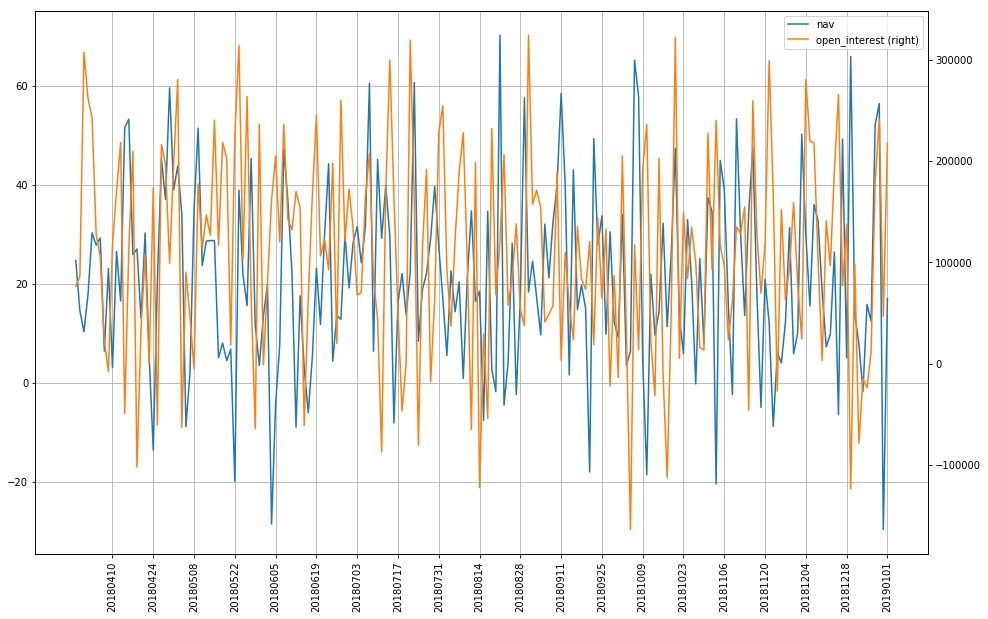

In [166]:
plot_pandas(df_in=df_merged[['trade_date','nav','open_interest']][-200:],x_column='trade_date');


<Figure size 432x288 with 0 Axes>

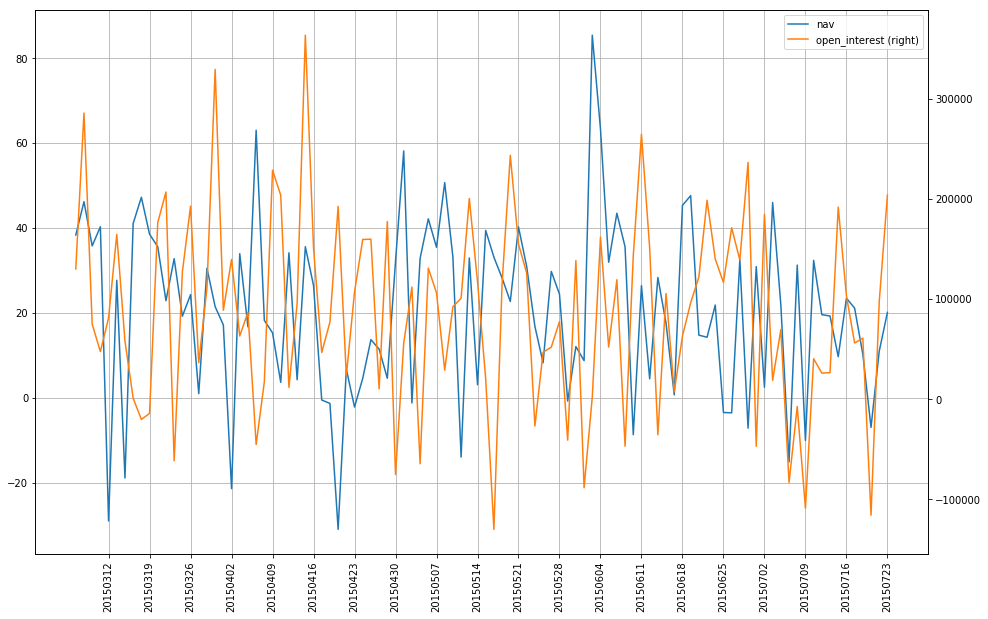

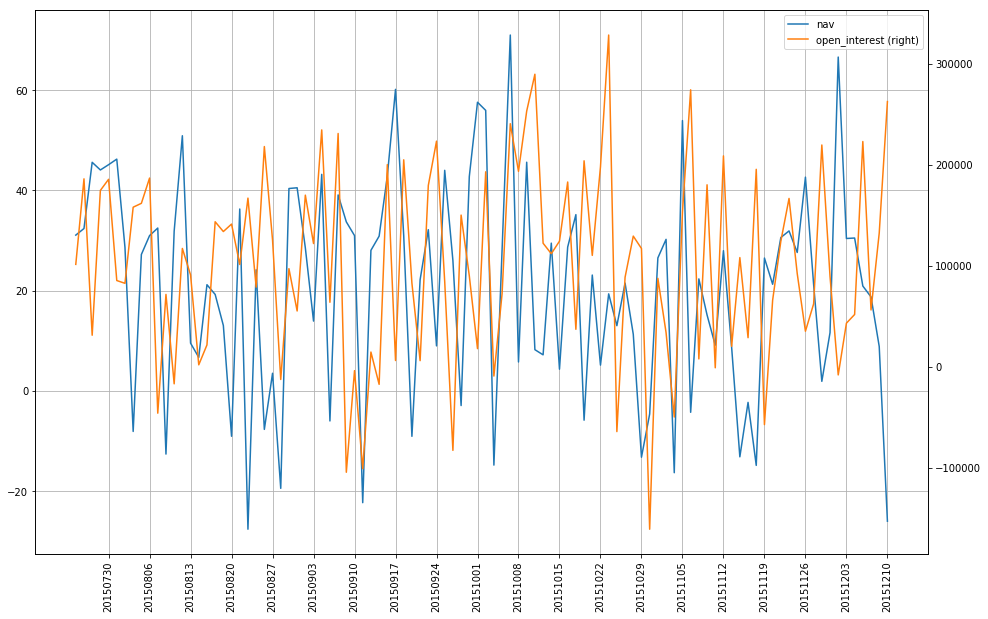

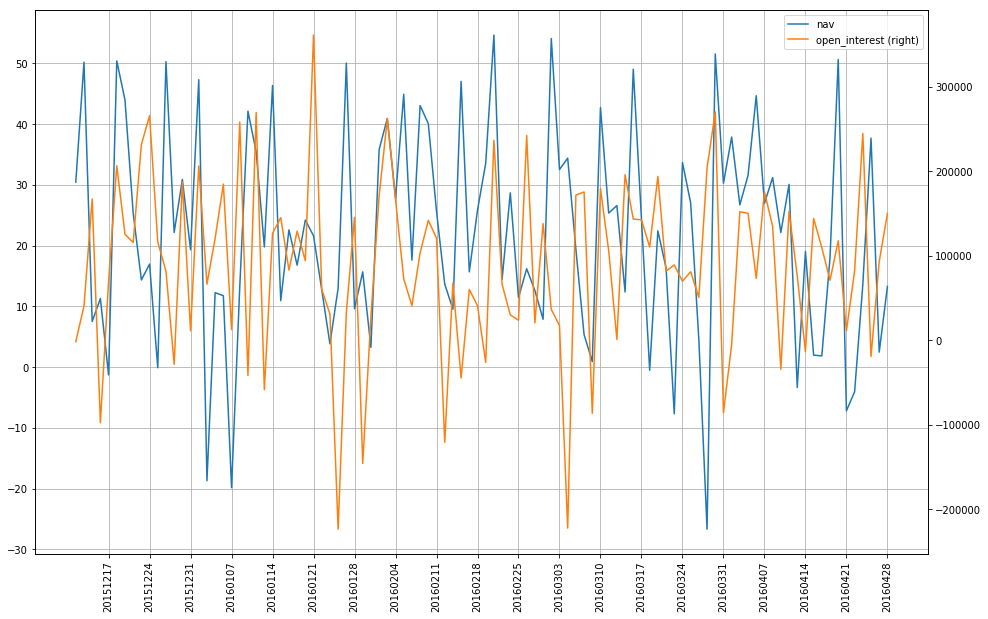

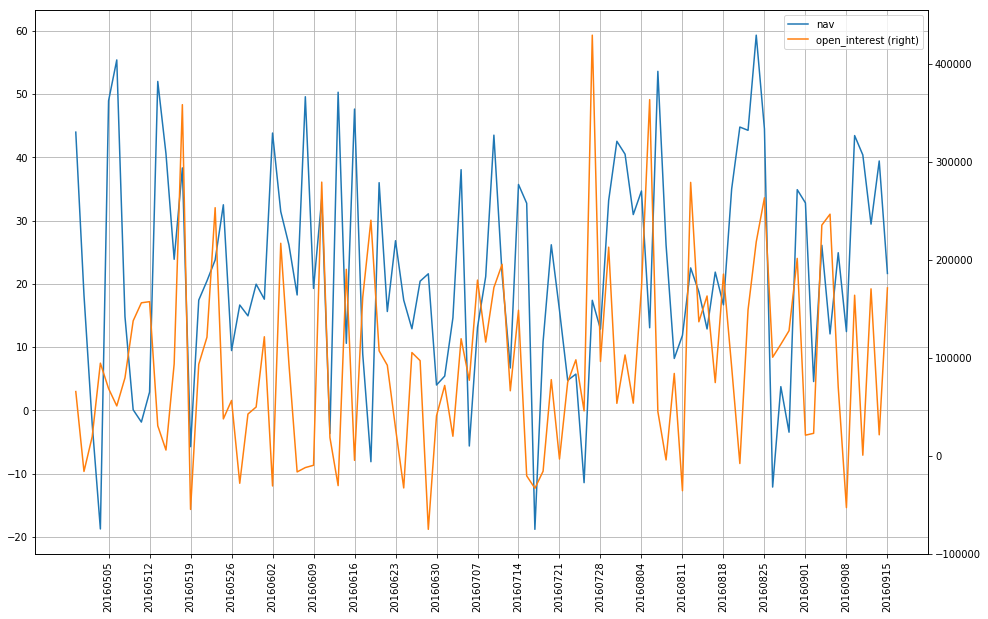

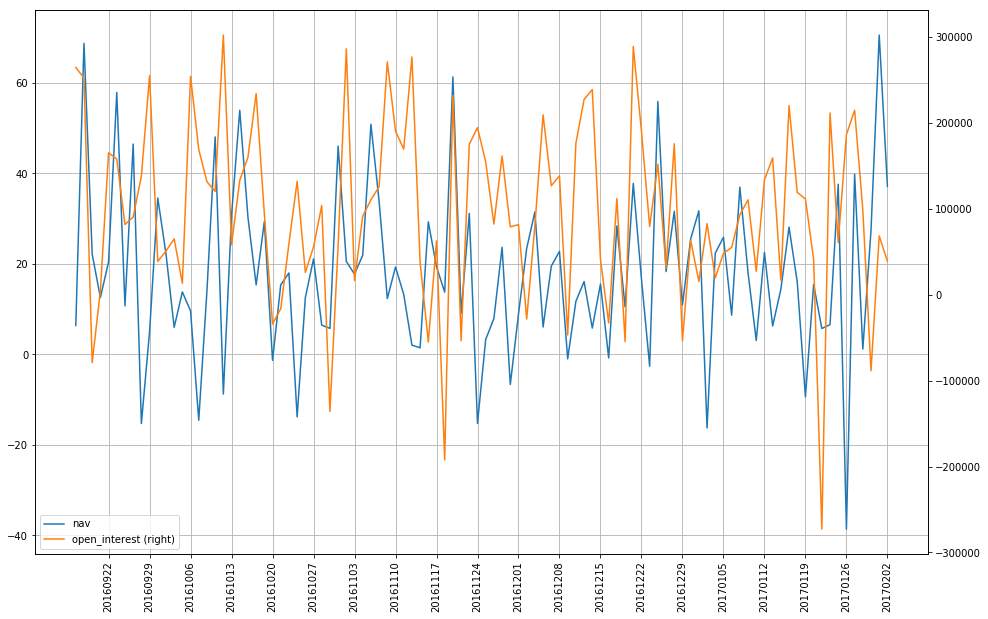

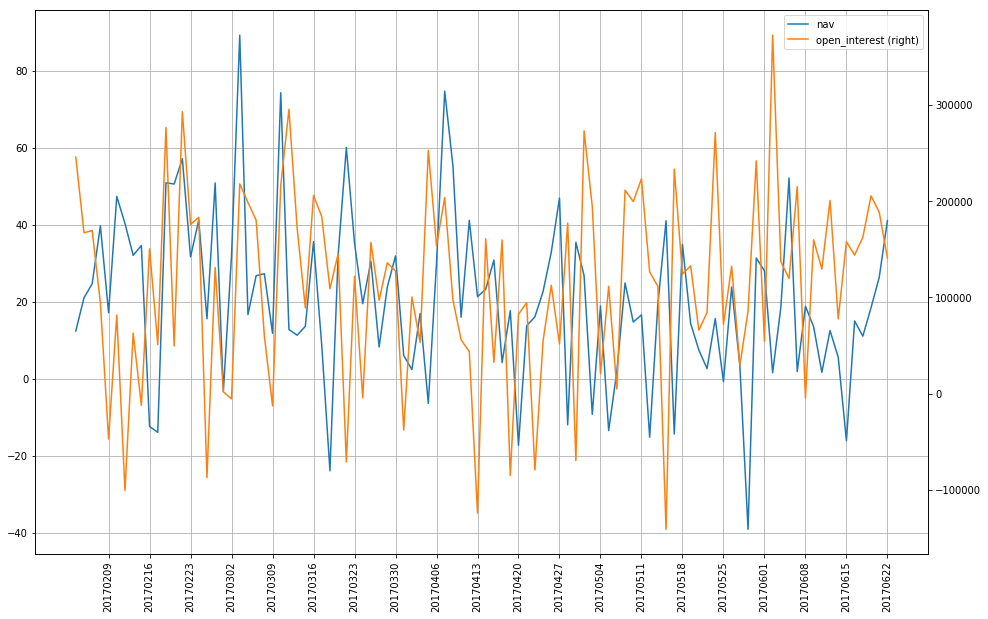

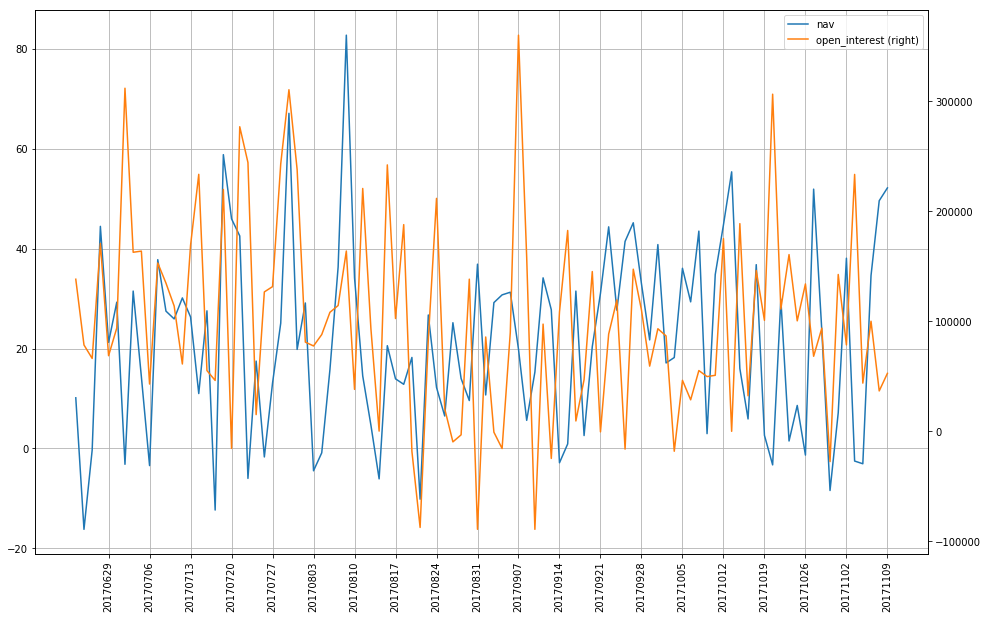

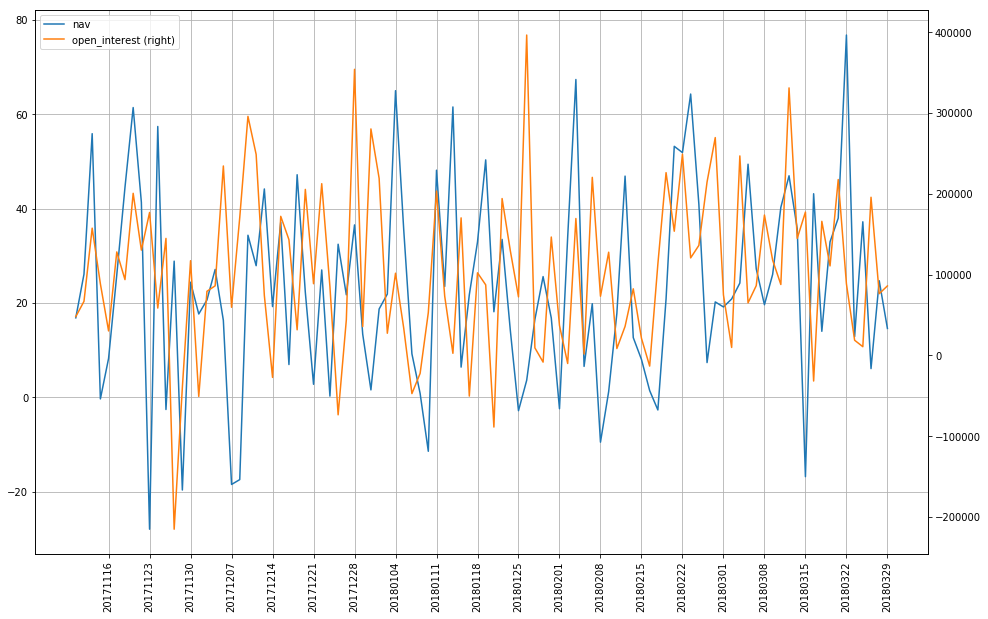

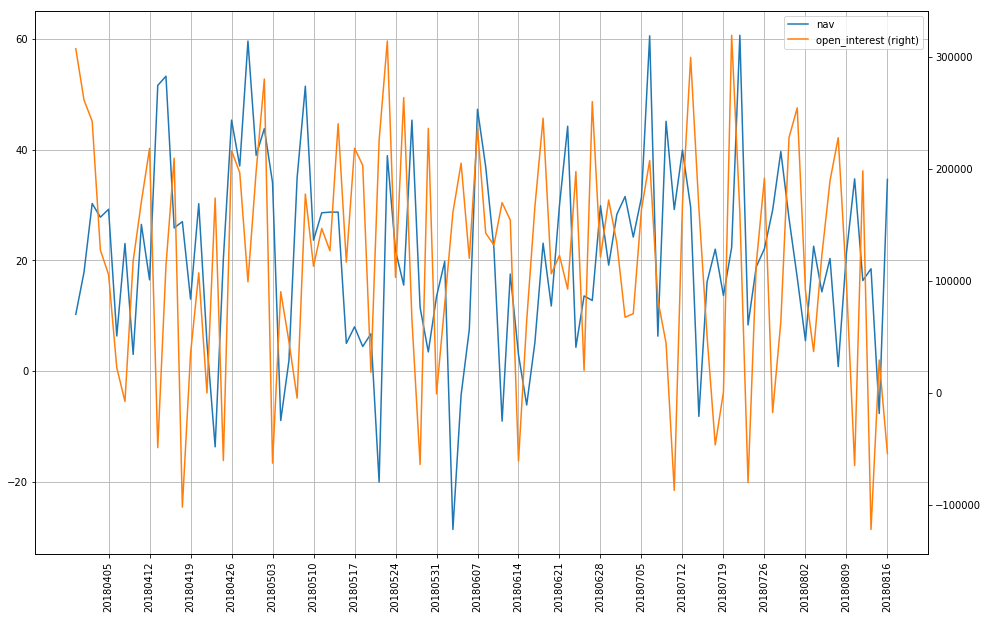

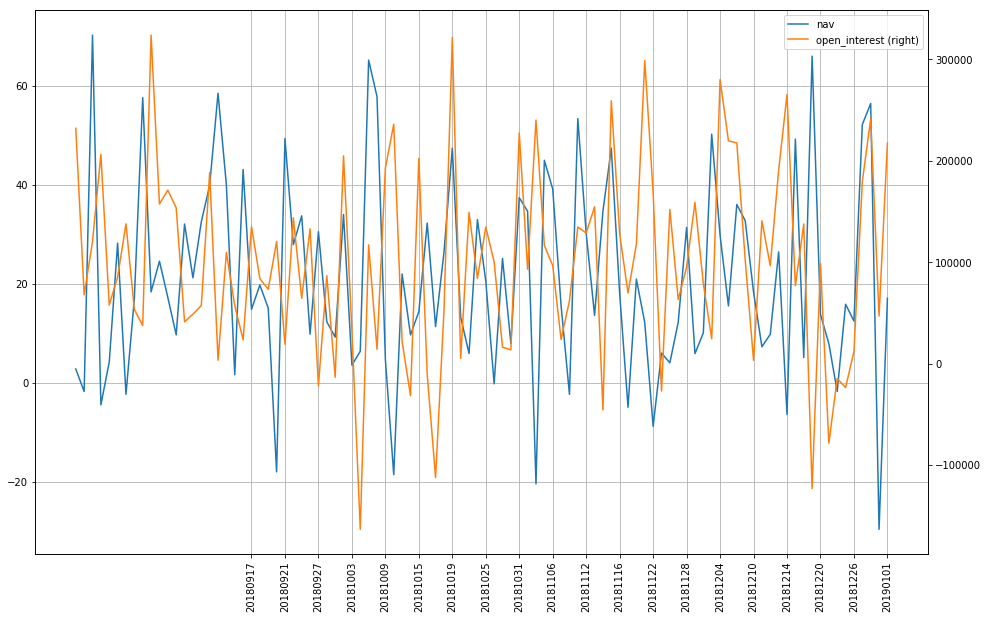

In [175]:
image_names = multi_plot(df_merged[['trade_date','nav','open_interest']],'trade_date','random_nav')

### Merge images into 1 vertically

In [176]:
imgs    = [ Image.open(i) for i in image_names ]
# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

# for a vertical stacking it is simple: use vstack
# imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
imgs_comb = np.vstack( (np.asarray(i) for i in imgs ) )
imgs_comb = Image.fromarray( imgs_comb)
save_file = f"{SAVED_IMAGE_FOLDER}/random_nav_all.png"
imgs_comb.save( save_file)

## END